## My model Final
### Vladimir Fyodorov
29.05.2022

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, SimpleRNN, Dropout
#import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

### About CDD/HDD
https://www.cmegroup.com/education/articles-and-reports/weather-options-overview.html

### Loading Data

https://www.youtube.com/watch?v=JWqLS51a2MM

https://www.ncdc.noaa.gov/cdo-web/

In [2]:
weather_data_path = 'Weather Data/'

# making list of cities
list_of_cities = ['Sacramento', 'Minneapolis', 'Las Vegas', 'New York', 'Amsterdam', 'Cincinnati', 'Dallas']
list_of_cities = sorted(list_of_cities)

# making empty weather dataset
df_weather = pd.read_csv(weather_data_path + 'Las Vegas 2015-2017.csv')
df_weather['City'] = 'Las Vegas'
df_weather = df_weather[0:0]

# filling weather dataset
for city in list_of_cities:
    df_weather_of_city = pd.read_csv(weather_data_path + city + ' 2015-2017.csv')
    df_weather_of_city['City'] = city
    df_weather = df_weather.append(df_weather_of_city)

# modifing dataset
df_weather['Date'] = pd.DatetimeIndex(df_weather['DATE']).date
df_weather = df_weather.reset_index()
df_weather['Temperature'] = (df_weather['TMAX'] + df_weather['TMIN'])/2

df_weather = df_weather[['Date', 'City', 'Temperature']]

# Calculating final temperature
df_weather_final = df_weather[0:0]
for city in list_of_cities:
    df_city = df_weather[df_weather['City'] == city]
    df_city = df_city.groupby(by=['Date']).mean()
    df_city['City'] = city
    df_weather_final = df_weather_final.append(df_city)

# making final version
df_weather_final = df_weather_final[['City', 'Temperature']]
df_weather_final.reset_index(level=0, inplace=True)
df_weather_final = df_weather_final.rename(columns={'index':'Date'})
df_weather_final['Temperature'] = df_weather_final['Temperature'].ffill()
df_weather_final = df_weather_final[['City', 'Date', 'Temperature']]

# making sliding windows
df_weather_final_2 = pd.DataFrame({'City': [], 'Date': [], 'Temperature': [], 'Rolling 5': []})

for city in list_of_cities:
    df_city = df_weather_final[df_weather_final['City'] == city]
    df_city['Rolling 5'] = df_city['Temperature'].rolling(5).mean()
    df_weather_final_2 = df_weather_final_2.append(df_city)

df_weather_final = df_weather_final_2[['City', 'Date', 'Temperature', 'Rolling 5']]
df_weather_final.rename(columns={'Temperature': 'Raw Temperature'}, inplace = True)

for i in range(len(list_of_cities)):
    df_weather_final['Is{}'.format(list_of_cities[i])] = np.where(df_weather_final['City'] == list_of_cities[i], 1, 0)

df_weather_final = df_weather_final[['Date', 'Raw Temperature', 'Rolling 5', 'IsSacramento', 'IsMinneapolis'
                                     , 'IsLas Vegas','IsNew York', 'IsAmsterdam', 'IsCincinnati', 'IsDallas']]
df_weather_final

,Date,Raw Temperature,Rolling 5,IsSacramento,IsMinneapolis,IsLas Vegas,IsNew York,IsAmsterdam,IsCincinnati,IsDallas
0,2015-01-01,-8.050000,NaN,0,0,0,0,1,0,0
1,2015-01-02,-5.425000,NaN,0,0,0,0,1,0,0
2,2015-01-03,-4.400000,NaN,0,0,0,0,1,0,0
3,2015-01-04,-3.050000,NaN,0,0,0,0,1,0,0
4,2015-01-05,-2.500000,-4.685000,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
7667,2017-12-27,8.083333,8.290000,1,0,0,0,0,0,0
7668,2017-12-28,8.450000,8.390000,1,0,0,0,0,0,0
7669,2017-12-29,8.533333,8.466667,1,0,0,0,0,0,0
7670,2017-12-30,8.250000,8.353333,1,0,0,0,0,0,0


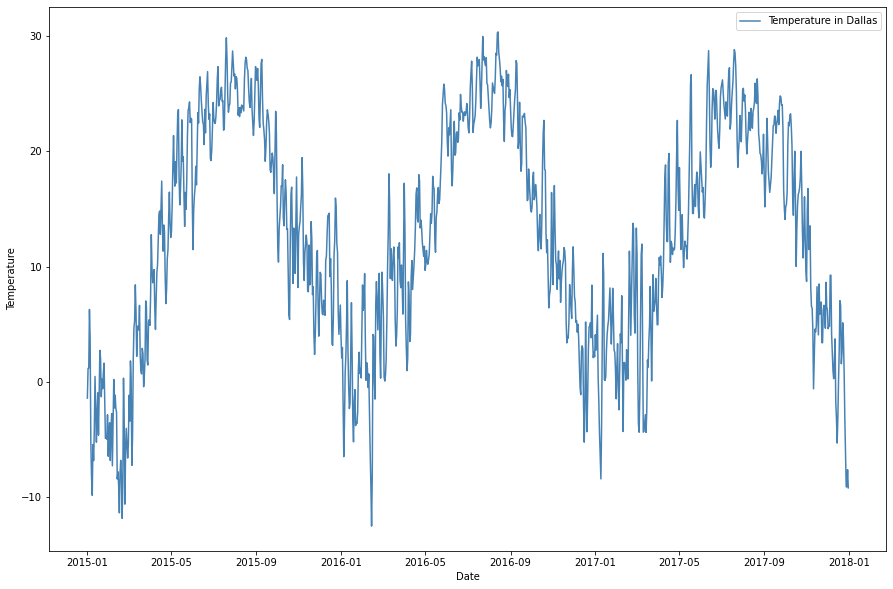

In [24]:
df_plot = df_weather_final[df_weather_final['IsNew York'] == 1]
#--------------------- Visualizing the RNN model results--------------------#
plt.figure(figsize=(15, 10))
plt.plot(df_plot['Date']
         , df_plot['Raw Temperature']
         , color = '#4782B4'
         , label = 'Temperature in {}'.format(list_of_cities[i]))
plt.xlabel("Date")
plt.ylabel('Temperature')
plt.legend()

plt.show()

### HDD/CDD Options data
HDD = MAX(0, 18°C - Daily Average Temperature), where DAT = (MIN(T_t) + MAX(T_t))/2

For example, if the average of a day's maximum and minimum temperature on a midnight-to-midnight basis is 11°C, that day's HDD is 7

In [3]:
financial_data_path = 'Financial Data/'

df_price_final = pd.read_excel(financial_data_path + 'HDD_Returns.xlsx', sheet_name = 'Sheet1')
df_price_final['Date'] = pd.DatetimeIndex(df_price_final['Date']).date
df_price_final.head()

,City,Date,Return
0,Sacramento,2015-11-02,0.000000
1,Sacramento,2015-11-03,-0.004268
2,Sacramento,2015-11-04,-0.009484
3,Sacramento,2015-11-05,0.001749
4,Sacramento,2015-11-06,-0.013142


In [11]:
df_price_final.groupby(by='City').count()

,Date,Return
City,,
Amsterdam,375,375
Cincinnati,374,374
Dallas,384,384
Las Vegas,414,414
Minneapolis,449,449
New York,384,384
Sacramento,325,325


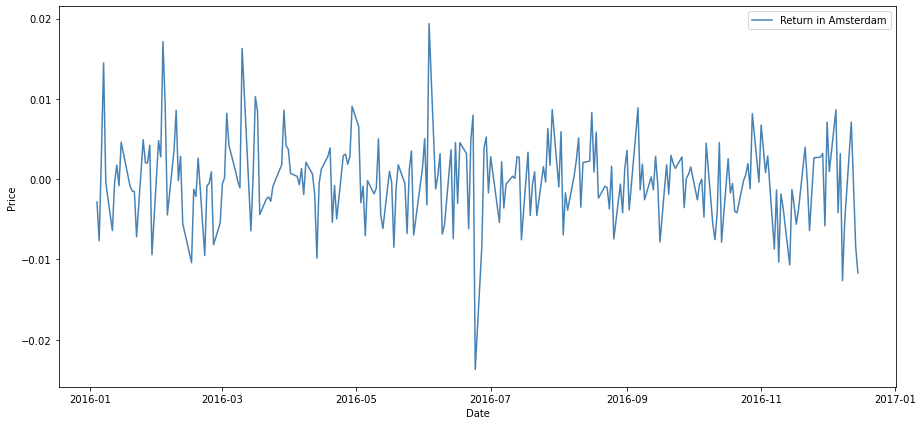

In [14]:
i = 4
df_plot = df_price_final[df_price_final['City'] == list_of_cities[i]]
df_plot = df_plot[pd.DatetimeIndex(df_plot['Date']).year == 2016]
df_plot = df_plot.sort_values(by='Date')
#--------------------- Visualizing the RNN model results--------------------#
plt.figure(figsize=(15, 7))
plt.plot(df_plot['Date']
         , df_plot['Return']
         , color = '#4782B4'
         , label = 'Return in {}'.format(list_of_cities[i])
        )
plt.xlabel("Date")
plt.ylabel('Price')
plt.legend()

plt.show()

# All models training by cities

In [4]:
output_metrics = 'Return'
input_metrics = 'Raw Temperature'
#input_metrics = 'Rolling 5'
window_days = 10
test_days = 50

In [32]:
#epochs_num_list = [5, 10, 20, 60, 100, 150]
epochs_num_list = [100, 100, 100]

Results = pd.DataFrame({ 'Forecast metric': []
                        , 'Input metric': []
                        , 'Number of epochs': []
                        , 'Number of input days': []
                        , 'City': []
                        , 'Model Type': []
                        , 'Loss train': []
                        , 'Loss test': []
                        , 'End Date-Time': []
                        , 'Model path': []
                       })


for city in list_of_cities:

    X_train_Corrected_Final = []
    X_test_Corrected_Final = []
    y_train_Final = []
    y_test_Final = []

    # for each city making datasets
    df_price_city = df_price_final[df_price_final['City'] == city]
    df_price_city = df_price_city[['Date', output_metrics]]
    df_price_city.reset_index(inplace=True, drop=True)

    df_weather_city = df_weather_final[df_weather_final['Is{}'.format(city)] == 1]
    df_weather_city.reset_index(inplace=True, drop=True)

    # Dropping 'IsDallas' => because other 0 is IsDallas
    df_weather_city = df_weather_city[['Date', input_metrics, 'IsSacramento', 'IsMinneapolis'
                                   , 'IsLas Vegas', 'IsNew York', 'IsAmsterdam', 'IsCincinnati']]


    # Train/Test start dates
    # Find Train output start day
    train_date_output_start = df_price_city['Date'].min()
    # Find Train intput start day (remember input is LAST 'window_days' of days)
    train_index_input_start = len(df_weather_city[df_weather_city['Date'] < train_date_output_start]) - window_days
    train_date_input_start = df_weather_city['Date'][train_index_input_start]

    # Test is LAST 'test_days' DAYS
    test_date_output_start = df_price_city['Date'][len(df_price_city) - test_days]
    # Find Train intput start day (remember input is LAST 'window_days' of days)
    test_index_input_start = len(df_weather_city[df_weather_city['Date'] < test_date_output_start]) - window_days
    test_date_input_start = df_weather_city['Date'][test_index_input_start]

    test_date_end = df_price_city['Date'].max()


    ##### Spliting datasets
    ### Train
    # input train data
    df_train_input = df_weather_city[df_weather_city['Date'] >= train_date_input_start]
    df_train_input = df_train_input[df_train_input['Date'] < test_date_output_start]
    training_input_set = df_train_input.iloc[:,1:2].values
    training_input_set_Dates = df_train_input.iloc[:,0:1].values
    training_input_set_DUMMY = df_train_input.iloc[:,2:].values

    # output train data
    df_train_output = df_price_city[df_price_city['Date'] >= train_date_output_start]
    df_train_output = df_train_output[df_train_output['Date'] < test_date_output_start]
    training_output_set = df_train_output.iloc[:,1:2].values
    training_output_set_Dates = df_train_output.iloc[:,0:1].values


    ### Test
    # input test data
    df_test_input = df_weather_city[df_weather_city['Date'] >= test_date_input_start]
    df_test_input = df_test_input[df_test_input['Date'] <= test_date_end]
    testing_input_set = df_test_input.iloc[:,1:2].values
    testing_input_set_Dates = df_test_input.iloc[:,0:1].values
    testing_input_set_DUMMY = df_test_input.iloc[:,2:].values

    # output test data
    df_test_output = df_price_city[df_price_city['Date'] >= test_date_output_start]
    df_test_output = df_test_output[df_test_output['Date'] <= test_date_end]
    testing_output_set = df_test_output.iloc[:,1:2].values
    testing_output_set_Dates = df_test_output.iloc[:,0:1].values


    ### Feature scaling
    sc_input, sc_output = MinMaxScaler(feature_range=(0,1)), MinMaxScaler(feature_range=(0,1))
    # scaling inputs
    training_input_set_scaled = sc_input.fit_transform(training_input_set)
    testing_input_set_scaled = sc_input.transform(testing_input_set)

    # scaling inputs
    training_output_set_scaled = sc_output.fit_transform(training_output_set)
    testing_output_set_scaled = sc_output.transform(testing_output_set)

    
    #creating a data structure with 90 timesteps + Dummy for city 8 (7 columns) and 1 output
    X_train = []
    X_train_Dates = []
    y_train = []
    y_train_Dates = []
    X_test  = []
    X_test_Dates  = []
    y_test  = []
    y_test_Dates  = []


    # transforming dataset
    for i in range(window_days, training_input_set_scaled.size):
        X_train.append(training_input_set_scaled[i-window_days:i, 0])
        X_train_Dates.append(training_input_set_Dates[i-window_days:i, 0])
        
        #X_train.append(np.append(training_input_set_DUMMY[0], training_input_set_scaled[i-window_days:i, 0], axis=0))
        #X_train_Dates.append(np.append(training_input_set_DUMMY[0], training_input_set_Dates[i-window_days:i, 0], axis=0))


    for i in range(0, training_output_set_scaled.size):
        y_train.append(training_output_set_scaled[i, 0])
        y_train_Dates.append(training_output_set_Dates[i, 0])


    for i in range(window_days, testing_input_set_scaled.size):
        X_test.append(testing_input_set_scaled[i-window_days:i, 0])
        X_test_Dates.append(testing_input_set_Dates[i-window_days:i, 0])
        
        #X_test.append(np.append(testing_input_set_DUMMY[0], testing_input_set_scaled[i-window_days:i, 0], axis=0))
        #X_test_Dates.append(np.append(testing_input_set_DUMMY[0], testing_input_set_Dates[i-window_days:i, 0], axis=0))


    for i in range(0, testing_output_set_scaled.size):
        y_test.append(testing_output_set_scaled[i, 0])
        y_test_Dates.append(testing_output_set_Dates[i, 0])


    # Financial data has gaps in dates therefore we have to drop missed days from weahter (input) datsets
    # Fixing of train set
    y_train_Dates_Corrected = [] # output is forecast therefore input - output is one day and we 
                                 # should correct for that
    X_train_Dates_Corrected = []
    X_train_Corrected = []

    for i in range(len(y_train_Dates)):
        # taking the day before
        y_train_Dates_Corrected.append(y_train_Dates[i] - dt.timedelta(days=1))

    y_train_Dates_Corrected_set = set(y_train_Dates_Corrected)


    for i in range(len(X_train_Dates)):
        # cheking whether we have an output for that dates 
        if X_train_Dates[i][-1] in y_train_Dates_Corrected_set:
            X_train_Dates_Corrected.append(X_train_Dates[i])
            X_train_Corrected.append(X_train[i])

    # Fixing of test set
    y_test_Dates_Corrected = [] # output is forecast therefore input - output is one day and we 
                                # should correct for that
    X_test_Dates_Corrected = []
    X_test_Corrected = []


    for i in range(len(y_test_Dates)):
        # taking the day before
        y_test_Dates_Corrected.append(y_test_Dates[i] - dt.timedelta(days=1))

    y_test_Dates_Corrected_set = set(y_test_Dates_Corrected)

    for i in range(len(X_test_Dates)):
        # cheking whether we have an output for that dates 
        if X_test_Dates[i][-1] in y_test_Dates_Corrected_set:
            X_test_Dates_Corrected.append(X_test_Dates[i])
            X_test_Corrected.append(X_test[i]) 
    
    # Adding Train/Test data sets of the city to the final dataset
    X_train_Corrected_Final += X_train_Corrected
    X_test_Corrected_Final += X_test_Corrected
    y_train_Final += y_train
    y_test_Final += y_test

    
    
    # transforming pandas lists to numpy arrays required for the RNN
    X_train, y_train = np.array(X_train_Corrected_Final), np.array(y_train_Final)
    X_test,  y_test  = np.array(X_test_Corrected_Final),  np.array(y_test_Final)

    # Shaping/adding new dimensions to allow adding more indicators: from 2D to 3D
    # 3 input arguments
    # batch_size: number of observations
    # timesteps: number of columns
    # input_dim: number of predictors
    X_train = np.reshape(X_train, [X_train.shape[0], X_train.shape[1], 1])
    X_test  = np.reshape(X_test,  [X_test.shape[0],  X_test.shape[1],  1])
    
    
    
    
    ########################   training models   #######################
    ####################################################################
    ####################################################################
    
    
    for epochs_num in epochs_num_list:

        ##########################    Model NN    ##########################
        ####################################################################
        regressor_NN = Sequential()

        # Laier plus dropout
        regressor_NN.add(Dense(units = 50, input_shape = (X_train.shape[1], 1)))

        # Output
        regressor_NN.add(Dense(units = 1))

        # Comipling
        regressor_NN.compile(optimizer = 'adam', loss = 'mean_squared_error')

        # Fitting
        regressor_NN.fit(X_train, y_train, epochs = epochs_num, batch_size = 32)

        # Testing
        NN_Loss_test  = round(regressor_NN.evaluate(X_test,  y_test ), 4)
        NN_Loss_train = round(regressor_NN.evaluate(X_train, y_train), 4)


        # Saving
        datetime_now = dt.datetime.now().strftime("%Y-%m-%d %H:%M")
        NN_model_path = 'Models/NN model | Input {} in {} | Epochs {} | Days {} | Loss train {} | Loss test {} | Created at {}.h5'.format(
            input_metrics, city, epochs_num, window_days, NN_Loss_train, NN_Loss_test, datetime_now)

        # Saving model
        regressor_NN.save(NN_model_path)
        # Saving resultes
        Results = Results.append(pd.DataFrame({ 'Forecast metric': [output_metrics]
                                                , 'Input metric': [input_metrics]
                                                , 'Number of epochs': [epochs_num]
                                                , 'Number of input days': [window_days]
                                                , 'City': [city]
                                                , 'Model Type': ['NN']
                                                , 'Loss train': [NN_Loss_train]
                                                , 'Loss test': [NN_Loss_test]
                                                , 'End Date-Time': [datetime_now]
                                                , 'Model path': [NN_model_path]
                                               }))



        ##########################    Model SimpleRNN    ##########################
        ###########################################################################
        regressor_RNN = Sequential()

        # Laier plus dropout
        regressor_RNN.add(SimpleRNN(units = 50, return_sequences=True, input_shape = (X_train.shape[1], 1)))
        #regressor_RNN.add(Dropout(0.2))

        # Output
        regressor_RNN.add(Dense(units = 1))

        # Comipling
        regressor_RNN.compile(optimizer = 'adam', loss = 'mean_squared_error')

        # Fitting
        regressor_RNN.fit(X_train, y_train, epochs = epochs_num, batch_size = 32)

        # Testing
        RNN_Loss_test  = round(regressor_RNN.evaluate(X_test,  y_test ), 4)
        RNN_Loss_train = round(regressor_RNN.evaluate(X_train, y_train), 4)

        # Saving
        datetime_now = dt.datetime.now().strftime("%Y-%m-%d %H:%M")
        RNN_model_path = 'Models/RNN model | Input {} in {} | Epochs {} | Days {} | Loss train {} | Loss test {} | Created at {}.h5'.format(
            input_metrics, city, epochs_num, window_days, RNN_Loss_train, RNN_Loss_test, datetime_now)

        # Saving model
        regressor_RNN.save(RNN_model_path)
        # Saving resultes
        Results = Results.append(pd.DataFrame({ 'Forecast metric': [output_metrics]
                                                , 'Input metric': [input_metrics]
                                                , 'Number of epochs': [epochs_num]
                                                , 'Number of input days': [window_days]
                                                , 'City': [city]
                                                , 'Model Type': ['SimpleRNN']
                                                , 'Loss train': [RNN_Loss_train]
                                                , 'Loss test': [RNN_Loss_test]
                                                , 'End Date-Time': [datetime_now]
                                                , 'Model path': [RNN_model_path]
                                               }))



        ##########################    Model LSTM    ##########################
        ######################################################################
        regressor_LSTM = Sequential()

        # Laier plus dropout
        regressor_LSTM.add(LSTM(units = 50, input_shape = (X_train.shape[1], 1)))
        regressor_LSTM.add(Dropout(0.2))

        # Output
        regressor_LSTM.add(Dense(units = 1))

        # Comipling
        regressor_LSTM.compile(optimizer = 'adam', loss = 'mean_squared_error')

        # Fitting
        regressor_LSTM.fit(X_train, y_train, epochs = epochs_num, batch_size = 32)

        # Testing
        LSTM_Loss_test  = round(regressor_LSTM.evaluate(X_test,  y_test ), 4)
        LSTM_Loss_train = round(regressor_LSTM.evaluate(X_train, y_train), 4)

        # Saving
        datetime_now = dt.datetime.now().strftime("%Y-%m-%d %H:%M")
        LSTM_model_path = 'Models/LSTM model | Input {} in {} | Epochs {} | Days {} | Loss train {} | Loss test {} | Created at {}.h5'.format(
            input_metrics, city, epochs_num, window_days, LSTM_Loss_train, LSTM_Loss_test, datetime_now)

        # Saving model
        regressor_LSTM.save(LSTM_model_path)
        # Saving resultes
        Results = Results.append(pd.DataFrame({ 'Forecast metric': [output_metrics]
                                                , 'Input metric': [input_metrics]
                                                , 'Number of epochs': [epochs_num]
                                                , 'Number of input days': [window_days]
                                                , 'City': [city]
                                                , 'Model Type': ['LSTM']
                                                , 'Loss train': [LSTM_Loss_train]
                                                , 'Loss test': [LSTM_Loss_test]
                                                , 'End Date-Time': [datetime_now]
                                                , 'Model path': [LSTM_model_path]
                                               }))



        ##########################    Model DLSTM    ##########################
        #######################################################################
        regressor_DLSTM = Sequential()

        # Laier plus dropout
        regressor_DLSTM.add(LSTM(units = 50, return_sequences=True, input_shape = (X_train.shape[1], 1)))
        regressor_DLSTM.add(Dropout(0.2))

        # Second Layer plus dropout
        regressor_DLSTM.add(LSTM(units = 50))
        regressor_DLSTM.add(Dropout(0.2))

        # Output
        regressor_DLSTM.add(Dense(units = 1))

        # Comipling
        regressor_DLSTM.compile(optimizer = 'adam', loss = 'mean_squared_error')

        # Fitting
        regressor_DLSTM.fit(X_train, y_train, epochs = epochs_num, batch_size = 32)

        # Testing
        DLSTM_Loss_test  = round(regressor_DLSTM.evaluate(X_test,  y_test ), 4)
        DLSTM_Loss_train = round(regressor_DLSTM.evaluate(X_train, y_train), 4)

        # Saving
        datetime_now = dt.datetime.now().strftime("%Y-%m-%d %H:%M")
        DLSTM_model_path = 'Models/DLSTM model | Input {} in {} | Epochs {} | Days {} | Loss train {} | Loss test {} | Created at {}.h5'.format(
            input_metrics, city, epochs_num, window_days, DLSTM_Loss_train, DLSTM_Loss_test, datetime_now)

        # Saving model
        regressor_DLSTM.save(DLSTM_model_path)
        # Saving resultes
        Results = Results.append(pd.DataFrame({ 'Forecast metric': [output_metrics]
                                                , 'Input metric': [input_metrics]
                                                , 'Number of epochs': [epochs_num]
                                                , 'Number of input days': [window_days]
                                                , 'City': [city]
                                                , 'Model Type': ['DLSTM']
                                                , 'Loss train': [DLSTM_Loss_train]
                                                , 'Loss test': [DLSTM_Loss_test]
                                                , 'End Date-Time': [datetime_now]
                                                , 'Model path': [DLSTM_model_path]
                                               }))



        ##########################    Model D-DLSTM    ##########################
        #########################################################################
        regressor_DDLSTM = Sequential()

        # First Layer plus dropout
        regressor_DDLSTM.add(LSTM(units = 50, return_sequences=True, input_shape = (X_train.shape[1], 1)))
        regressor_DDLSTM.add(Dropout(0.2))

        # Second Layer plus dropout
        regressor_DDLSTM.add(LSTM(units = 50, return_sequences=True))
        regressor_DDLSTM.add(Dropout(0.2))

        # Third Layer plus dropout
        regressor_DDLSTM.add(LSTM(units = 50, return_sequences=True))
        regressor_DDLSTM.add(Dropout(0.2))

        # Forth Layer plus dropout
        regressor_DDLSTM.add(LSTM(units = 50, return_sequences=True))
        regressor_DDLSTM.add(Dropout(0.2))

        # Fifth Layer plus dropout
        regressor_DDLSTM.add(LSTM(units = 50))
        regressor_DDLSTM.add(Dropout(0.2))

        # Output
        regressor_DDLSTM.add(Dense(units = 1))

        # Comipling
        regressor_DDLSTM.compile(optimizer = 'adam', loss = 'mean_squared_error')

        # Fitting
        regressor_DDLSTM.fit(X_train, y_train, epochs = epochs_num, batch_size = 32)

        # Testing
        DDLSTM_Loss_test  = round(regressor_DDLSTM.evaluate(X_test,  y_test ), 4)
        DDLSTM_Loss_train = round(regressor_DDLSTM.evaluate(X_train, y_train), 4)

        # Saving
        datetime_now = dt.datetime.now().strftime("%Y-%m-%d %H:%M")
        DDLSTM_model_path = 'Models/DDLSTM model | Input {} in {} | Epochs {} | Days {} | Loss train {} | Loss test {} | Created at {}.h5'.format(
            input_metrics, city, epochs_num, window_days, DDLSTM_Loss_train, DDLSTM_Loss_test, datetime_now)

        # Saving model
        regressor_DDLSTM.save(DDLSTM_model_path)
        # Saving resultes
        Results = Results.append(pd.DataFrame({ 'Forecast metric': [output_metrics]
                                                , 'Input metric': [input_metrics]
                                                , 'Number of epochs': [epochs_num]
                                                , 'Number of input days': [window_days]
                                                , 'City': [city]
                                                , 'Model Type': ['DDLSTM']
                                                , 'Loss train': [DDLSTM_Loss_train]
                                                , 'Loss test': [DDLSTM_Loss_test]
                                                , 'End Date-Time': [datetime_now]
                                                , 'Model path': [DDLSTM_model_path]
                                               }))
    
Results.reset_index(inplace=True, drop=True)
datetime_now = dt.datetime.now().strftime("%Y-%m-%d %H:%M")
Results.to_excel('Results Excel/Input {} by Cities | Epochs 10 | Days {} | Created at {}.xlsx'.format(
    input_metrics, window_days, datetime_now))

Epoch 1/100
11/11 [==============================] - 1s 3ms/step - loss: 0.1271
Epoch 2/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0328
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0171
Epoch 4/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0188
Epoch 5/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0166
Epoch 6/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0158
Epoch 7/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 8/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0151
Epoch 9/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0147
Epoch 10/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0149
Epoch 11/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0142
Epoch 12/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0139
Epoch 13/100
11/11 [=================

11/11 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 1/100
11/11 [==============================] - 3s 11ms/step - loss: 0.1793
Epoch 2/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0314
Epoch 3/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0283
Epoch 4/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0219
Epoch 5/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0225
Epoch 6/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0219
Epoch 7/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0200
Epoch 8/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0185
Epoch 9/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0181
Epoch 10/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0176
Epoch 11/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0167
Epoch 12/100
11/11 [======================

11/11 [==============================] - 0s 28ms/step - loss: 0.0124
Epoch 98/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0127
Epoch 99/100
11/11 [==============================] - 0s 17ms/step - loss: 0.0126
Epoch 100/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0115
Epoch 1/100
11/11 [==============================] - 13s 52ms/step - loss: 0.1007
Epoch 2/100
11/11 [==============================] - 0s 44ms/step - loss: 0.0328
Epoch 3/100
11/11 [==============================] - 1s 49ms/step - loss: 0.0190
Epoch 4/100
11/11 [==============================] - 1s 48ms/step - loss: 0.0163
Epoch 5/100
11/11 [==============================] - 1s 52ms/step - loss: 0.0164
Epoch 6/100
11/11 [==============================] - 0s 41ms/step - loss: 0.0151
Epoch 7/100
11/11 [==============================] - 0s 38ms/step - loss: 0.0154
Epoch 8/100
11/11 [==============================] - 0s 37ms/step - loss: 0.0134
Epoch 9/100
11/11 [=================

11/11 [==============================] - 0s 2ms/step - loss: 0.0116
Epoch 95/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 96/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 97/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 98/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 99/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 100/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0115
Epoch 1/100
11/11 [==============================] - 1s 5ms/step - loss: 0.0399
Epoch 2/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0224
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0158
Epoch 4/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0140
Epoch 5/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0149
Epoch 6/100
11/11 [==========================

11/11 [==============================] - 0s 11ms/step - loss: 0.0121
Epoch 92/100
11/11 [==============================] - 0s 12ms/step - loss: 0.0121
Epoch 93/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0123
Epoch 94/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0124
Epoch 95/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0124
Epoch 96/100
11/11 [==============================] - 0s 12ms/step - loss: 0.0126
Epoch 97/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0125
Epoch 98/100
11/11 [==============================] - 0s 13ms/step - loss: 0.0126
Epoch 99/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0122
Epoch 100/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0118
Epoch 1/100
11/11 [==============================] - 6s 24ms/step - loss: 0.0687
Epoch 2/100
11/11 [==============================] - 0s 19ms/step - loss: 0.0282
Epoch 3/100
11/11 [============

11/11 [==============================] - 0s 39ms/step - loss: 0.0130
Epoch 88/100
11/11 [==============================] - 0s 45ms/step - loss: 0.0134
Epoch 89/100
11/11 [==============================] - 1s 48ms/step - loss: 0.0132
Epoch 90/100
11/11 [==============================] - 0s 45ms/step - loss: 0.0124
Epoch 91/100
11/11 [==============================] - 0s 38ms/step - loss: 0.0122
Epoch 92/100
11/11 [==============================] - 0s 41ms/step - loss: 0.0126
Epoch 93/100
11/11 [==============================] - 0s 39ms/step - loss: 0.0119
Epoch 94/100
11/11 [==============================] - 0s 40ms/step - loss: 0.0124
Epoch 95/100
11/11 [==============================] - 0s 42ms/step - loss: 0.0127
Epoch 96/100
11/11 [==============================] - 0s 40ms/step - loss: 0.0124
Epoch 97/100
11/11 [==============================] - 0s 43ms/step - loss: 0.0123
Epoch 98/100
11/11 [==============================] - 0s 42ms/step - loss: 0.0123
Epoch 99/100
11/11 [=========

11/11 [==============================] - 0s 6ms/step - loss: 0.0118
Epoch 86/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0117
Epoch 87/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0116
Epoch 88/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0123
Epoch 89/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0134
Epoch 90/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0130
Epoch 91/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0130
Epoch 92/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0127
Epoch 93/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0122
Epoch 94/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0118
Epoch 95/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0127
Epoch 96/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0122
Epoch 97/100
11/11 [=====================

Epoch 84/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0123
Epoch 85/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0130
Epoch 86/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0128
Epoch 87/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0130
Epoch 88/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0127
Epoch 89/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0127
Epoch 90/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0124
Epoch 91/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0122
Epoch 92/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0120
Epoch 93/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0131
Epoch 94/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0120
Epoch 95/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0123
Epoch 96/100
11/11 [=======

11/11 [==============================] - 0s 41ms/step - loss: 0.0118
Epoch 81/100
11/11 [==============================] - 0s 38ms/step - loss: 0.0126
Epoch 82/100
11/11 [==============================] - 0s 39ms/step - loss: 0.0128
Epoch 83/100
11/11 [==============================] - 0s 38ms/step - loss: 0.0125
Epoch 84/100
11/11 [==============================] - 0s 38ms/step - loss: 0.0122
Epoch 85/100
11/11 [==============================] - 0s 38ms/step - loss: 0.0123
Epoch 86/100
11/11 [==============================] - 0s 39ms/step - loss: 0.0134
Epoch 87/100
11/11 [==============================] - 0s 39ms/step - loss: 0.0127
Epoch 88/100
11/11 [==============================] - 0s 39ms/step - loss: 0.0134
Epoch 89/100
11/11 [==============================] - 0s 39ms/step - loss: 0.0133
Epoch 90/100
11/11 [==============================] - 0s 40ms/step - loss: 0.0126
Epoch 91/100
11/11 [==============================] - 0s 37ms/step - loss: 0.0128
Epoch 92/100
11/11 [=========

11/11 [==============================] - 0s 5ms/step - loss: 0.0101
Epoch 79/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0101
Epoch 80/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0102
Epoch 81/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0101
Epoch 82/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0101
Epoch 83/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0101
Epoch 84/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0121
Epoch 85/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0106
Epoch 86/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0105
Epoch 87/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0104
Epoch 88/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0103
Epoch 89/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0101
Epoch 90/100
11/11 [=====================

11/11 [==============================] - 0s 21ms/step - loss: 0.0110
Epoch 76/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0114
Epoch 77/100
11/11 [==============================] - 0s 15ms/step - loss: 0.0116
Epoch 78/100
11/11 [==============================] - 0s 17ms/step - loss: 0.0107
Epoch 79/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0107
Epoch 80/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0111
Epoch 81/100
11/11 [==============================] - 0s 19ms/step - loss: 0.0104
Epoch 82/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0106
Epoch 83/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0108
Epoch 84/100
11/11 [==============================] - 0s 17ms/step - loss: 0.0110
Epoch 85/100
11/11 [==============================] - 0s 17ms/step - loss: 0.0109
Epoch 86/100
11/11 [==============================] - 0s 17ms/step - loss: 0.0113
Epoch 87/100
11/11 [=========

11/11 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 73/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 74/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch 75/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0103
Epoch 76/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0100
Epoch 77/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0101
Epoch 78/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0101
Epoch 79/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0100
Epoch 80/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0101
Epoch 81/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0101
Epoch 82/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0101
Epoch 83/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0100
Epoch 84/100
11/11 [=====================

11/11 [==============================] - 0s 9ms/step - loss: 0.0107
Epoch 71/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0112
Epoch 72/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0108
Epoch 73/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0107
Epoch 74/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0114
Epoch 75/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0117
Epoch 76/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0106
Epoch 77/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0112
Epoch 78/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0111
Epoch 79/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0106
Epoch 80/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0109
Epoch 81/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0108
Epoch 82/100
11/11 [===================

11/11 [==============================] - 0s 40ms/step - loss: 0.0114
Epoch 67/100
11/11 [==============================] - 0s 38ms/step - loss: 0.0114
Epoch 68/100
11/11 [==============================] - 0s 39ms/step - loss: 0.0115
Epoch 69/100
11/11 [==============================] - 0s 39ms/step - loss: 0.0114
Epoch 70/100
11/11 [==============================] - 0s 39ms/step - loss: 0.0103
Epoch 71/100
11/11 [==============================] - 0s 39ms/step - loss: 0.0111
Epoch 72/100
11/11 [==============================] - 0s 38ms/step - loss: 0.0110
Epoch 73/100
11/11 [==============================] - 0s 37ms/step - loss: 0.0108
Epoch 74/100
11/11 [==============================] - 0s 39ms/step - loss: 0.0120
Epoch 75/100
11/11 [==============================] - 0s 39ms/step - loss: 0.0113
Epoch 76/100
11/11 [==============================] - 0s 39ms/step - loss: 0.0109
Epoch 77/100
11/11 [==============================] - 0s 42ms/step - loss: 0.0108
Epoch 78/100
11/11 [=========

11/11 [==============================] - 0s 5ms/step - loss: 0.0102
Epoch 65/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0101
Epoch 66/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0101
Epoch 67/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0101
Epoch 68/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0106
Epoch 69/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0109
Epoch 70/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0117
Epoch 71/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0104
Epoch 72/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0110
Epoch 73/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0105
Epoch 74/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0103
Epoch 75/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0103
Epoch 76/100
11/11 [=====================

11/11 [==============================] - 0s 17ms/step - loss: 0.0114
Epoch 62/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0114
Epoch 63/100
11/11 [==============================] - 0s 15ms/step - loss: 0.0116
Epoch 64/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0115
Epoch 65/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0114
Epoch 66/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0113
Epoch 67/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0119
Epoch 68/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0116
Epoch 69/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0116
Epoch 70/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0105
Epoch 71/100
11/11 [==============================] - 0s 17ms/step - loss: 0.0109
Epoch 72/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0112
Epoch 73/100
11/11 [=========

11/11 [==============================] - 0s 3ms/step - loss: 0.0106
Epoch 59/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0106
Epoch 60/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0107
Epoch 61/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0105
Epoch 62/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 63/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0106
Epoch 64/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0106
Epoch 65/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0106
Epoch 66/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0106
Epoch 67/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0108
Epoch 68/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0106
Epoch 69/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0106
Epoch 70/100
11/11 [====================

11/11 [==============================] - 0s 9ms/step - loss: 0.0120
Epoch 57/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0118
Epoch 58/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0120
Epoch 59/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0121
Epoch 60/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0121
Epoch 61/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0118
Epoch 62/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0121
Epoch 63/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0122
Epoch 64/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0123
Epoch 65/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0117
Epoch 66/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0119
Epoch 67/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0111
Epoch 68/100
11/11 [===================

11/11 [==============================] - 0s 41ms/step - loss: 0.0114
Epoch 53/100
11/11 [==============================] - 0s 39ms/step - loss: 0.0127
Epoch 54/100
11/11 [==============================] - 0s 40ms/step - loss: 0.0114
Epoch 55/100
11/11 [==============================] - 0s 39ms/step - loss: 0.0110
Epoch 56/100
11/11 [==============================] - 0s 38ms/step - loss: 0.0116
Epoch 57/100
11/11 [==============================] - 0s 39ms/step - loss: 0.0118
Epoch 58/100
11/11 [==============================] - 0s 43ms/step - loss: 0.0114
Epoch 59/100
11/11 [==============================] - 0s 40ms/step - loss: 0.0107
Epoch 60/100
11/11 [==============================] - 0s 39ms/step - loss: 0.0113
Epoch 61/100
11/11 [==============================] - 0s 38ms/step - loss: 0.0121
Epoch 62/100
11/11 [==============================] - 0s 38ms/step - loss: 0.0123
Epoch 63/100
11/11 [==============================] - 0s 38ms/step - loss: 0.0113
Epoch 64/100
11/11 [=========

11/11 [==============================] - 0s 3ms/step - loss: 0.0106
Epoch 52/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 53/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0106
Epoch 54/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0106
Epoch 55/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 56/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 57/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0106
Epoch 58/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 59/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0106
Epoch 60/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0106
Epoch 61/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0106
Epoch 62/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0106
Epoch 63/100
11/11 [=====================

11/11 [==============================] - 0s 10ms/step - loss: 0.0117
Epoch 50/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0118
Epoch 51/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0118
Epoch 52/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0114
Epoch 53/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0120
Epoch 54/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0126
Epoch 55/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0114
Epoch 56/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0118
Epoch 57/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0120
Epoch 58/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0117
Epoch 59/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0119
Epoch 60/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0124
Epoch 61/100
11/11 [===============

11/11 [==============================] - 0s 39ms/step - loss: 0.0118
Epoch 46/100
11/11 [==============================] - 0s 39ms/step - loss: 0.0122
Epoch 47/100
11/11 [==============================] - 0s 39ms/step - loss: 0.0126
Epoch 48/100
11/11 [==============================] - 0s 39ms/step - loss: 0.0121
Epoch 49/100
11/11 [==============================] - 0s 39ms/step - loss: 0.0120
Epoch 50/100
11/11 [==============================] - 0s 43ms/step - loss: 0.0114
Epoch 51/100
11/11 [==============================] - 0s 38ms/step - loss: 0.0119
Epoch 52/100
11/11 [==============================] - 0s 39ms/step - loss: 0.0114
Epoch 53/100
11/11 [==============================] - 0s 39ms/step - loss: 0.0120
Epoch 54/100
11/11 [==============================] - 0s 38ms/step - loss: 0.0120
Epoch 55/100
11/11 [==============================] - 0s 40ms/step - loss: 0.0119
Epoch 56/100
11/11 [==============================] - 0s 39ms/step - loss: 0.0112
Epoch 57/100
11/11 [=========

11/11 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 45/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 46/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0106
Epoch 47/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0106
Epoch 48/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 49/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 50/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 51/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 52/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0106
Epoch 53/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 54/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 55/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0106
Epoch 56/100
11/11 [=====================

11/11 [==============================] - 0s 10ms/step - loss: 0.0122
Epoch 43/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0109
Epoch 44/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0113
Epoch 45/100
11/11 [==============================] - 0s 13ms/step - loss: 0.0119
Epoch 46/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0116
Epoch 47/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0117
Epoch 48/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0128
Epoch 49/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0123
Epoch 50/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0118
Epoch 51/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0127
Epoch 52/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0123
Epoch 53/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0127
Epoch 54/100
11/11 [=================

Epoch 41/100
11/11 [==============================] - 0s 18ms/step - loss: 0.0114
Epoch 42/100
11/11 [==============================] - 0s 18ms/step - loss: 0.0118
Epoch 43/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0123
Epoch 44/100
11/11 [==============================] - 0s 17ms/step - loss: 0.0114
Epoch 45/100
11/11 [==============================] - 0s 17ms/step - loss: 0.0127
Epoch 46/100
11/11 [==============================] - 0s 17ms/step - loss: 0.0119
Epoch 47/100
11/11 [==============================] - 0s 17ms/step - loss: 0.0121
Epoch 48/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0118
Epoch 49/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0115
Epoch 50/100
11/11 [==============================] - 0s 17ms/step - loss: 0.0115
Epoch 51/100
11/11 [==============================] - 0s 18ms/step - loss: 0.0118
Epoch 52/100
11/11 [==============================] - 0s 17ms/step - loss: 0.0114
Epoch 53/100
11/

Epoch 38/100
12/12 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 39/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 40/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 41/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 42/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 43/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 44/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 45/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 46/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 47/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 48/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 49/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 50/100
12/12 [========

12/12 [==============================] - 0s 9ms/step - loss: 0.0126
Epoch 37/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0132
Epoch 38/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0133
Epoch 39/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0125
Epoch 40/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0128
Epoch 41/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0129
Epoch 42/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0124
Epoch 43/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0126
Epoch 44/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0135
Epoch 45/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0128
Epoch 46/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0132
Epoch 47/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0130
Epoch 48/100
12/12 [=====================

Epoch 35/100
12/12 [==============================] - 0s 17ms/step - loss: 0.0134
Epoch 36/100
12/12 [==============================] - 0s 17ms/step - loss: 0.0130
Epoch 37/100
12/12 [==============================] - 0s 17ms/step - loss: 0.0132
Epoch 38/100
12/12 [==============================] - 0s 17ms/step - loss: 0.0129
Epoch 39/100
12/12 [==============================] - 0s 18ms/step - loss: 0.0140
Epoch 40/100
12/12 [==============================] - 0s 17ms/step - loss: 0.0130
Epoch 41/100
12/12 [==============================] - 0s 17ms/step - loss: 0.0137
Epoch 42/100
12/12 [==============================] - 0s 16ms/step - loss: 0.0134
Epoch 43/100
12/12 [==============================] - 0s 16ms/step - loss: 0.0133
Epoch 44/100
12/12 [==============================] - 0s 16ms/step - loss: 0.0128
Epoch 45/100
12/12 [==============================] - 0s 17ms/step - loss: 0.0128
Epoch 46/100
12/12 [==============================] - 0s 17ms/step - loss: 0.0125
Epoch 47/100
12/

12/12 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 32/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 33/100
12/12 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 34/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 35/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 36/100
12/12 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 37/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 38/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 39/100
12/12 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 40/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 41/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 42/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 43/100
12/12 [=====================

12/12 [==============================] - 0s 10ms/step - loss: 0.0127
Epoch 30/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0130
Epoch 31/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0138
Epoch 32/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0132
Epoch 33/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0128
Epoch 34/100
12/12 [==============================] - 0s 10ms/step - loss: 0.0130
Epoch 35/100
12/12 [==============================] - 0s 10ms/step - loss: 0.0128
Epoch 36/100
12/12 [==============================] - 0s 12ms/step - loss: 0.0140
Epoch 37/100
12/12 [==============================] - 0s 8ms/step - loss: 0.0138
Epoch 38/100
12/12 [==============================] - 0s 13ms/step - loss: 0.0130
Epoch 39/100
12/12 [==============================] - 0s 10ms/step - loss: 0.0126
Epoch 40/100
12/12 [==============================] - 0s 10ms/step - loss: 0.0131
Epoch 41/100
12/12 [==============

12/12 [==============================] - 0s 16ms/step - loss: 0.0128
Epoch 29/100
12/12 [==============================] - 0s 18ms/step - loss: 0.0132
Epoch 30/100
12/12 [==============================] - 0s 17ms/step - loss: 0.0127
Epoch 31/100
12/12 [==============================] - 0s 17ms/step - loss: 0.0133
Epoch 32/100
12/12 [==============================] - 0s 17ms/step - loss: 0.0132
Epoch 33/100
12/12 [==============================] - 0s 17ms/step - loss: 0.0130
Epoch 34/100
12/12 [==============================] - 0s 18ms/step - loss: 0.0130
Epoch 35/100
12/12 [==============================] - 0s 18ms/step - loss: 0.0130
Epoch 36/100
12/12 [==============================] - 0s 16ms/step - loss: 0.0130
Epoch 37/100
12/12 [==============================] - 0s 16ms/step - loss: 0.0132
Epoch 38/100
12/12 [==============================] - 0s 17ms/step - loss: 0.0129
Epoch 39/100
12/12 [==============================] - 0s 17ms/step - loss: 0.0137
Epoch 40/100
12/12 [=========

12/12 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 25/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 26/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 27/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 28/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 29/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 30/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 31/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 32/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 33/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 34/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 35/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 36/100
12/12 [=====================

12/12 [==============================] - 0s 9ms/step - loss: 0.0132
Epoch 23/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0133
Epoch 24/100
12/12 [==============================] - 0s 8ms/step - loss: 0.0132
Epoch 25/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0132
Epoch 26/100
12/12 [==============================] - 0s 8ms/step - loss: 0.0125
Epoch 27/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0135
Epoch 28/100
12/12 [==============================] - 0s 8ms/step - loss: 0.0125
Epoch 29/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0130
Epoch 30/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0131
Epoch 31/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0132
Epoch 32/100
12/12 [==============================] - 0s 10ms/step - loss: 0.0146
Epoch 33/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0136
Epoch 34/100
12/12 [====================

12/12 [==============================] - 0s 39ms/step - loss: 0.0133
Epoch 19/100
12/12 [==============================] - 0s 39ms/step - loss: 0.0134
Epoch 20/100
12/12 [==============================] - 0s 39ms/step - loss: 0.0136
Epoch 21/100
12/12 [==============================] - 0s 39ms/step - loss: 0.0127
Epoch 22/100
12/12 [==============================] - 0s 39ms/step - loss: 0.0130
Epoch 23/100
12/12 [==============================] - 0s 39ms/step - loss: 0.0126
Epoch 24/100
12/12 [==============================] - 0s 39ms/step - loss: 0.0132
Epoch 25/100
12/12 [==============================] - 0s 39ms/step - loss: 0.0131
Epoch 26/100
12/12 [==============================] - 0s 39ms/step - loss: 0.0136
Epoch 27/100
12/12 [==============================] - 0s 40ms/step - loss: 0.0131
Epoch 28/100
12/12 [==============================] - 0s 39ms/step - loss: 0.0123
Epoch 29/100
12/12 [==============================] - 0s 40ms/step - loss: 0.0131
Epoch 30/100
12/12 [=========

13/13 [==============================] - 0s 6ms/step - loss: 0.0123
Epoch 16/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0123
Epoch 17/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0123
Epoch 18/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0123
Epoch 19/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0122
Epoch 20/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0129
Epoch 21/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0121
Epoch 22/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0121
Epoch 23/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0123
Epoch 24/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0126
Epoch 25/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0151
Epoch 26/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0135
Epoch 27/100
13/13 [=====================

13/13 [==============================] - 0s 17ms/step - loss: 0.0142
Epoch 14/100
13/13 [==============================] - 0s 17ms/step - loss: 0.0130
Epoch 15/100
13/13 [==============================] - 0s 17ms/step - loss: 0.0139
Epoch 16/100
13/13 [==============================] - 0s 16ms/step - loss: 0.0129
Epoch 17/100
13/13 [==============================] - 0s 15ms/step - loss: 0.0142
Epoch 18/100
13/13 [==============================] - 0s 16ms/step - loss: 0.0126
Epoch 19/100
13/13 [==============================] - 0s 16ms/step - loss: 0.0143
Epoch 20/100
13/13 [==============================] - 0s 17ms/step - loss: 0.0133
Epoch 21/100
13/13 [==============================] - 0s 17ms/step - loss: 0.0134
Epoch 22/100
13/13 [==============================] - 0s 17ms/step - loss: 0.0132
Epoch 23/100
13/13 [==============================] - 0s 17ms/step - loss: 0.0139
Epoch 24/100
13/13 [==============================] - 0s 17ms/step - loss: 0.0134
Epoch 25/100
13/13 [=========

13/13 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 10/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0140
Epoch 11/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 12/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 13/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 14/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 15/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 16/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 17/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 18/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 19/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0124
Epoch 20/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0123
Epoch 21/100
13/13 [=====================

13/13 [==============================] - 0s 9ms/step - loss: 0.0179
Epoch 8/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0168
Epoch 9/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0154
Epoch 10/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0157
Epoch 11/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0154
Epoch 12/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0152
Epoch 13/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0142
Epoch 14/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0146
Epoch 15/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0146
Epoch 16/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0151
Epoch 17/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0136
Epoch 18/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0143
Epoch 19/100
13/13 [=====================

13/13 [==============================] - 1s 40ms/step - loss: 0.0138
Epoch 5/100
13/13 [==============================] - 1s 39ms/step - loss: 0.0126
Epoch 6/100
13/13 [==============================] - 1s 40ms/step - loss: 0.0140
Epoch 7/100
13/13 [==============================] - 1s 39ms/step - loss: 0.0136
Epoch 8/100
13/13 [==============================] - 1s 40ms/step - loss: 0.0139
Epoch 9/100
13/13 [==============================] - 1s 40ms/step - loss: 0.0133
Epoch 10/100
13/13 [==============================] - 1s 39ms/step - loss: 0.0127
Epoch 11/100
13/13 [==============================] - 1s 39ms/step - loss: 0.0142
Epoch 12/100
13/13 [==============================] - 1s 39ms/step - loss: 0.0139
Epoch 13/100
13/13 [==============================] - 1s 39ms/step - loss: 0.0133
Epoch 14/100
13/13 [==============================] - 0s 38ms/step - loss: 0.0133
Epoch 15/100
13/13 [==============================] - 0s 37ms/step - loss: 0.0139
Epoch 16/100
13/13 [==============

13/13 [==============================] - 1s 6ms/step - loss: 0.0349
Epoch 2/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0205
Epoch 3/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0158
Epoch 4/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0141
Epoch 5/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0139
Epoch 6/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0134
Epoch 7/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0131
Epoch 8/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0142
Epoch 9/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0131
Epoch 10/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0127
Epoch 11/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0131
Epoch 12/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0130
Epoch 13/100
13/13 [=============================

13/13 [==============================] - 0s 4ms/step - loss: 0.0121
Epoch 1/100
13/13 [==============================] - 5s 19ms/step - loss: 0.0687
Epoch 2/100
13/13 [==============================] - 0s 17ms/step - loss: 0.0238
Epoch 3/100
13/13 [==============================] - 0s 17ms/step - loss: 0.0215
Epoch 4/100
13/13 [==============================] - 0s 17ms/step - loss: 0.0188
Epoch 5/100
13/13 [==============================] - 0s 16ms/step - loss: 0.0179
Epoch 6/100
13/13 [==============================] - 0s 16ms/step - loss: 0.0171
Epoch 7/100
13/13 [==============================] - 0s 18ms/step - loss: 0.0161
Epoch 8/100
13/13 [==============================] - 0s 17ms/step - loss: 0.0149
Epoch 9/100
13/13 [==============================] - 0s 18ms/step - loss: 0.0141
Epoch 10/100
13/13 [==============================] - 0s 17ms/step - loss: 0.0149
Epoch 11/100
13/13 [==============================] - 0s 17ms/step - loss: 0.0139
Epoch 12/100
13/13 [===================

13/13 [==============================] - 1s 38ms/step - loss: 0.0125
Epoch 97/100
13/13 [==============================] - 1s 38ms/step - loss: 0.0125
Epoch 98/100
13/13 [==============================] - 1s 39ms/step - loss: 0.0128
Epoch 99/100
13/13 [==============================] - 1s 39ms/step - loss: 0.0123
Epoch 100/100
13/13 [==============================] - 0s 12ms/step - loss: 0.0117
Epoch 1/100
11/11 [==============================] - 1s 3ms/step - loss: 0.0883
Epoch 2/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0219
Epoch 3/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0191
Epoch 4/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0180
Epoch 5/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0163
Epoch 6/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0159
Epoch 7/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0148
Epoch 8/100
11/11 [=======================

11/11 [==============================] - 0s 6ms/step - loss: 0.0109
Epoch 95/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0106
Epoch 96/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0109
Epoch 97/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0108
Epoch 98/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0108
Epoch 99/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0105
Epoch 100/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0111
Epoch 1/100
11/11 [==============================] - 3s 11ms/step - loss: 0.0658
Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0304
Epoch 3/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0224
Epoch 4/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0210
Epoch 5/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0189
Epoch 6/100
11/11 [========================

11/11 [==============================] - 0s 9ms/step - loss: 0.0111
Epoch 94/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0113
Epoch 95/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0112
Epoch 96/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0111
Epoch 97/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0116
Epoch 98/100
11/11 [==============================] - 0s 12ms/step - loss: 0.0117
Epoch 99/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0118
Epoch 100/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0108
Epoch 1/100
11/11 [==============================] - 5s 21ms/step - loss: 0.0744
Epoch 2/100
11/11 [==============================] - 0s 18ms/step - loss: 0.0258
Epoch 3/100
11/11 [==============================] - 0s 17ms/step - loss: 0.0214
Epoch 4/100
11/11 [==============================] - 0s 17ms/step - loss: 0.0176
Epoch 5/100
11/11 [===================

11/11 [==============================] - 0s 39ms/step - loss: 0.0111
Epoch 90/100
11/11 [==============================] - 0s 39ms/step - loss: 0.0113
Epoch 91/100
11/11 [==============================] - 0s 39ms/step - loss: 0.0122
Epoch 92/100
11/11 [==============================] - 0s 40ms/step - loss: 0.0118
Epoch 93/100
11/11 [==============================] - 0s 40ms/step - loss: 0.0115
Epoch 94/100
11/11 [==============================] - 0s 38ms/step - loss: 0.0111
Epoch 95/100
11/11 [==============================] - 0s 40ms/step - loss: 0.0117
Epoch 96/100
11/11 [==============================] - 0s 39ms/step - loss: 0.0117
Epoch 97/100
11/11 [==============================] - 0s 39ms/step - loss: 0.0117
Epoch 98/100
11/11 [==============================] - 0s 39ms/step - loss: 0.0121
Epoch 99/100
11/11 [==============================] - 0s 40ms/step - loss: 0.0111
Epoch 100/100
11/11 [==============================] - 0s 13ms/step - loss: 0.0106
Epoch 1/100
11/11 [=========

11/11 [==============================] - 0s 6ms/step - loss: 0.0107
Epoch 88/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0108
Epoch 89/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0109
Epoch 90/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0113
Epoch 91/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0108
Epoch 92/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0108
Epoch 93/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0108
Epoch 94/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0109
Epoch 95/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0110
Epoch 96/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0108
Epoch 97/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0107
Epoch 98/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0106
Epoch 99/100
11/11 [=====================

11/11 [==============================] - 0s 9ms/step - loss: 0.0122
Epoch 87/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0113
Epoch 88/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0111
Epoch 89/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0117
Epoch 90/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0115
Epoch 91/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0111
Epoch 92/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0117
Epoch 93/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0117
Epoch 94/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0114
Epoch 95/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0119
Epoch 96/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0119
Epoch 97/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0116
Epoch 98/100
11/11 [================

11/11 [==============================] - 0s 38ms/step - loss: 0.0115
Epoch 83/100
11/11 [==============================] - 0s 38ms/step - loss: 0.0116
Epoch 84/100
11/11 [==============================] - 0s 40ms/step - loss: 0.0115
Epoch 85/100
11/11 [==============================] - 0s 38ms/step - loss: 0.0109
Epoch 86/100
11/11 [==============================] - 0s 39ms/step - loss: 0.0108
Epoch 87/100
11/11 [==============================] - 0s 39ms/step - loss: 0.0118
Epoch 88/100
11/11 [==============================] - 0s 37ms/step - loss: 0.0113
Epoch 89/100
11/11 [==============================] - 0s 38ms/step - loss: 0.0113
Epoch 90/100
11/11 [==============================] - 0s 38ms/step - loss: 0.0115
Epoch 91/100
11/11 [==============================] - 0s 39ms/step - loss: 0.0115
Epoch 92/100
11/11 [==============================] - 0s 39ms/step - loss: 0.0120
Epoch 93/100
11/11 [==============================] - 0s 39ms/step - loss: 0.0113
Epoch 94/100
11/11 [=========

11/11 [==============================] - 0s 5ms/step - loss: 0.0118
Epoch 81/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0109
Epoch 82/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0110
Epoch 83/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0110
Epoch 84/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0110
Epoch 85/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0106
Epoch 86/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0108
Epoch 87/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0107
Epoch 88/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0107
Epoch 89/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0107
Epoch 90/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0108
Epoch 91/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0107
Epoch 92/100
11/11 [=====================

11/11 [==============================] - 0s 16ms/step - loss: 0.0115
Epoch 78/100
11/11 [==============================] - 0s 15ms/step - loss: 0.0119
Epoch 79/100
11/11 [==============================] - 0s 18ms/step - loss: 0.0117
Epoch 80/100
11/11 [==============================] - 0s 17ms/step - loss: 0.0117
Epoch 81/100
11/11 [==============================] - 0s 18ms/step - loss: 0.0107
Epoch 82/100
11/11 [==============================] - 0s 18ms/step - loss: 0.0110
Epoch 83/100
11/11 [==============================] - 0s 17ms/step - loss: 0.0109
Epoch 84/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0117
Epoch 85/100
11/11 [==============================] - 0s 17ms/step - loss: 0.0119
Epoch 86/100
11/11 [==============================] - 0s 17ms/step - loss: 0.0120
Epoch 87/100
11/11 [==============================] - 0s 17ms/step - loss: 0.0117
Epoch 88/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0116
Epoch 89/100
11/11 [=========

9/9 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 77/100
9/9 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 78/100
9/9 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 79/100
9/9 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 80/100
9/9 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 81/100
9/9 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 82/100
9/9 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 83/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0102
Epoch 84/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0102
Epoch 85/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0102
Epoch 86/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0102
Epoch 87/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0102
Epoch 88/100
9/9 [==============================] - 0s 3ms/step -

9/9 [==============================] - 0s 9ms/step - loss: 0.0122
Epoch 80/100
9/9 [==============================] - 0s 9ms/step - loss: 0.0118
Epoch 81/100
9/9 [==============================] - 0s 9ms/step - loss: 0.0113
Epoch 82/100
9/9 [==============================] - 0s 9ms/step - loss: 0.0113
Epoch 83/100
9/9 [==============================] - 0s 10ms/step - loss: 0.0111
Epoch 84/100
9/9 [==============================] - 0s 10ms/step - loss: 0.0105
Epoch 85/100
9/9 [==============================] - 0s 9ms/step - loss: 0.0105
Epoch 86/100
9/9 [==============================] - 0s 10ms/step - loss: 0.0113
Epoch 87/100
9/9 [==============================] - 0s 9ms/step - loss: 0.0118
Epoch 88/100
9/9 [==============================] - 0s 9ms/step - loss: 0.0116
Epoch 89/100
9/9 [==============================] - 0s 9ms/step - loss: 0.0111
Epoch 90/100
9/9 [==============================] - 0s 10ms/step - loss: 0.0111
Epoch 91/100
9/9 [==============================] - 0s 9ms/st

9/9 [==============================] - 0s 39ms/step - loss: 0.0108
Epoch 82/100
9/9 [==============================] - 0s 41ms/step - loss: 0.0111
Epoch 83/100
9/9 [==============================] - 0s 36ms/step - loss: 0.0109
Epoch 84/100
9/9 [==============================] - 0s 38ms/step - loss: 0.0107
Epoch 85/100
9/9 [==============================] - 0s 37ms/step - loss: 0.0109
Epoch 86/100
9/9 [==============================] - 0s 36ms/step - loss: 0.0105
Epoch 87/100
9/9 [==============================] - 0s 37ms/step - loss: 0.0113
Epoch 88/100
9/9 [==============================] - 0s 38ms/step - loss: 0.0105
Epoch 89/100
9/9 [==============================] - 0s 39ms/step - loss: 0.0112
Epoch 90/100
9/9 [==============================] - 0s 38ms/step - loss: 0.0113
Epoch 91/100
9/9 [==============================] - 0s 38ms/step - loss: 0.0115
Epoch 92/100
9/9 [==============================] - 0s 39ms/step - loss: 0.0109
Epoch 93/100
9/9 [==============================] - 0

9/9 [==============================] - 0s 3ms/step - loss: 0.0102
Epoch 84/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0102
Epoch 85/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0102
Epoch 86/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0102
Epoch 87/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0102
Epoch 88/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0102
Epoch 89/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0102
Epoch 90/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0102
Epoch 91/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0102
Epoch 92/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0102
Epoch 93/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0102
Epoch 94/100
9/9 [==============================] - 0s 4ms/step - loss: 0.0103
Epoch 95/100
9/9 [==============================] - 0s 3ms/step -

9/9 [==============================] - 0s 11ms/step - loss: 0.0111
Epoch 87/100
9/9 [==============================] - 0s 10ms/step - loss: 0.0114
Epoch 88/100
9/9 [==============================] - 0s 10ms/step - loss: 0.0109
Epoch 89/100
9/9 [==============================] - 0s 12ms/step - loss: 0.0110
Epoch 90/100
9/9 [==============================] - 0s 9ms/step - loss: 0.0111
Epoch 91/100
9/9 [==============================] - 0s 11ms/step - loss: 0.0102
Epoch 92/100
9/9 [==============================] - 0s 9ms/step - loss: 0.0108
Epoch 93/100
9/9 [==============================] - 0s 9ms/step - loss: 0.0114
Epoch 94/100
9/9 [==============================] - 0s 12ms/step - loss: 0.0113
Epoch 95/100
9/9 [==============================] - 0s 10ms/step - loss: 0.0108
Epoch 96/100
9/9 [==============================] - 0s 11ms/step - loss: 0.0108
Epoch 97/100
9/9 [==============================] - 0s 11ms/step - loss: 0.0111
Epoch 98/100
9/9 [==============================] - 0s 1

9/9 [==============================] - 0s 20ms/step - loss: 0.0117
Epoch 88/100
9/9 [==============================] - 0s 16ms/step - loss: 0.0099
Epoch 89/100
9/9 [==============================] - 0s 20ms/step - loss: 0.0114
Epoch 90/100
9/9 [==============================] - 0s 17ms/step - loss: 0.0111
Epoch 91/100
9/9 [==============================] - 0s 17ms/step - loss: 0.0113
Epoch 92/100
9/9 [==============================] - 0s 15ms/step - loss: 0.0112
Epoch 93/100
9/9 [==============================] - 0s 21ms/step - loss: 0.0111
Epoch 94/100
9/9 [==============================] - 0s 20ms/step - loss: 0.0117
Epoch 95/100
9/9 [==============================] - 0s 19ms/step - loss: 0.0111
Epoch 96/100
9/9 [==============================] - 0s 17ms/step - loss: 0.0114
Epoch 97/100
9/9 [==============================] - 0s 17ms/step - loss: 0.0107
Epoch 98/100
9/9 [==============================] - 0s 15ms/step - loss: 0.0120
Epoch 99/100
9/9 [==============================] - 0

9/9 [==============================] - 0s 49ms/step - loss: 0.0113
Epoch 89/100
9/9 [==============================] - 0s 46ms/step - loss: 0.0109
Epoch 90/100
9/9 [==============================] - 0s 43ms/step - loss: 0.0120
Epoch 91/100
9/9 [==============================] - 0s 49ms/step - loss: 0.0107
Epoch 92/100
9/9 [==============================] - 0s 45ms/step - loss: 0.0105
Epoch 93/100
9/9 [==============================] - 1s 56ms/step - loss: 0.0113
Epoch 94/100
9/9 [==============================] - 0s 51ms/step - loss: 0.0113
Epoch 95/100
9/9 [==============================] - 0s 48ms/step - loss: 0.0101
Epoch 96/100
9/9 [==============================] - 0s 48ms/step - loss: 0.0112
Epoch 97/100
9/9 [==============================] - 0s 48ms/step - loss: 0.0112
Epoch 98/100
9/9 [==============================] - 0s 40ms/step - loss: 0.0104
Epoch 99/100
9/9 [==============================] - 0s 48ms/step - loss: 0.0111
Epoch 100/100
9/9 [==============================] - 

9/9 [==============================] - 0s 5ms/step - loss: 0.0102
Epoch 91/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0102
Epoch 92/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0102
Epoch 93/100
9/9 [==============================] - 0s 4ms/step - loss: 0.0103
Epoch 94/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0102
Epoch 95/100
9/9 [==============================] - 0s 2ms/step - loss: 0.0103
Epoch 96/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0103
Epoch 97/100
9/9 [==============================] - 0s 4ms/step - loss: 0.0102
Epoch 98/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0102
Epoch 99/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0102
Epoch 100/100
9/9 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 1/100
9/9 [==============================] - 2s 5ms/step - loss: 0.1454
Epoch 2/100
9/9 [==============================] - 0s 7ms/step - 

9/9 [==============================] - 0s 9ms/step - loss: 0.0115
Epoch 95/100
9/9 [==============================] - 0s 9ms/step - loss: 0.0111
Epoch 96/100
9/9 [==============================] - 0s 9ms/step - loss: 0.0115
Epoch 97/100
9/9 [==============================] - 0s 9ms/step - loss: 0.0113
Epoch 98/100
9/9 [==============================] - 0s 9ms/step - loss: 0.0109
Epoch 99/100
9/9 [==============================] - 0s 9ms/step - loss: 0.0109
Epoch 100/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0103
Epoch 1/100
9/9 [==============================] - 5s 19ms/step - loss: 0.1158
Epoch 2/100
9/9 [==============================] - 0s 16ms/step - loss: 0.0360
Epoch 3/100
9/9 [==============================] - 0s 16ms/step - loss: 0.0239
Epoch 4/100
9/9 [==============================] - 0s 17ms/step - loss: 0.0226
Epoch 5/100
9/9 [==============================] - 0s 15ms/step - loss: 0.0184
Epoch 6/100
9/9 [==============================] - 0s 15ms/step 

9/9 [==============================] - 0s 16ms/step - loss: 0.0104
Epoch 96/100
9/9 [==============================] - 0s 17ms/step - loss: 0.0110
Epoch 97/100
9/9 [==============================] - 0s 17ms/step - loss: 0.0111
Epoch 98/100
9/9 [==============================] - 0s 17ms/step - loss: 0.0114
Epoch 99/100
9/9 [==============================] - 0s 18ms/step - loss: 0.0114
Epoch 100/100
9/9 [==============================] - 0s 6ms/step - loss: 0.0101
Epoch 1/100
9/9 [==============================] - 14s 50ms/step - loss: 0.1183
Epoch 2/100
9/9 [==============================] - 0s 42ms/step - loss: 0.0289
Epoch 3/100
9/9 [==============================] - 0s 46ms/step - loss: 0.0191
Epoch 4/100
9/9 [==============================] - 0s 40ms/step - loss: 0.0135
Epoch 5/100
9/9 [==============================] - 0s 40ms/step - loss: 0.0112
Epoch 6/100
9/9 [==============================] - 0s 40ms/step - loss: 0.0124
Epoch 7/100
9/9 [==============================] - 0s 39ms

9/9 [==============================] - 0s 40ms/step - loss: 0.0112
Epoch 97/100
9/9 [==============================] - 0s 39ms/step - loss: 0.0118
Epoch 98/100
9/9 [==============================] - 0s 41ms/step - loss: 0.0113
Epoch 99/100
9/9 [==============================] - 0s 42ms/step - loss: 0.0108
Epoch 100/100
9/9 [==============================] - 0s 12ms/step - loss: 0.0101


In [33]:
Results.head()

,Forecast metric,Input metric,Number of epochs,Number of input days,City,Model Type,Loss train,Loss test,End Date-Time,Model path
0,Return,Raw Temperature,100.0,10.0,Amsterdam,NN,0.0115,0.0087,2022-05-30 18:02,Models/NN model | Input Raw Temperature in Ams...
1,Return,Raw Temperature,100.0,10.0,Amsterdam,SimpleRNN,0.0116,0.0088,2022-05-30 18:02,Models/RNN model | Input Raw Temperature in Am...
2,Return,Raw Temperature,100.0,10.0,Amsterdam,LSTM,0.0115,0.0085,2022-05-30 18:02,Models/LSTM model | Input Raw Temperature in A...
3,Return,Raw Temperature,100.0,10.0,Amsterdam,DLSTM,0.0115,0.0089,2022-05-30 18:03,Models/DLSTM model | Input Raw Temperature in ...
4,Return,Raw Temperature,100.0,10.0,Amsterdam,DDLSTM,0.0116,0.0087,2022-05-30 18:04,Models/DDLSTM model | Input Raw Temperature in...


In [34]:
best_models = pd.DataFrame({ 'Forecast metric': []
                        , 'Input metric': []
                        , 'Number of epochs': []
                        , 'Number of input days': []
                        , 'City': []
                        , 'Model Type': []
                        , 'Loss train': []
                        , 'Loss test': []
                        , 'End Date-Time': []
                        , 'Model path': []
                       })
for city in list_of_cities:
    Results_city = Results[Results['City'] == city]
    
    for model in set(Results_city['Model Type']):
        Results_model = Results_city[Results_city['Model Type'] == model]
        min_score = Results_model['Loss test'].min()
        min_index = Results_model[Results_model['Loss test'] == min_score].index.min()
        best_models = best_models.append(Results_model[Results_model.index == min_index])

best_models

,Forecast metric,Input metric,Number of epochs,Number of input days,City,Model Type,Loss train,Loss test,End Date-Time,Model path
2,Return,Raw Temperature,100.0,10.0,Amsterdam,LSTM,0.0115,0.0085,2022-05-30 18:02,Models/LSTM model | Input Raw Temperature in A...
6,Return,Raw Temperature,100.0,10.0,Amsterdam,SimpleRNN,0.0117,0.0087,2022-05-30 18:04,Models/RNN model | Input Raw Temperature in Am...
8,Return,Raw Temperature,100.0,10.0,Amsterdam,DLSTM,0.0115,0.0087,2022-05-30 18:05,Models/DLSTM model | Input Raw Temperature in ...
4,Return,Raw Temperature,100.0,10.0,Amsterdam,DDLSTM,0.0116,0.0087,2022-05-30 18:04,Models/DDLSTM model | Input Raw Temperature in...
0,Return,Raw Temperature,100.0,10.0,Amsterdam,NN,0.0115,0.0087,2022-05-30 18:02,Models/NN model | Input Raw Temperature in Ams...
27,Return,Raw Temperature,100.0,10.0,Cincinnati,LSTM,0.0100,0.0060,2022-05-30 18:13,Models/LSTM model | Input Raw Temperature in C...
21,Return,Raw Temperature,100.0,10.0,Cincinnati,SimpleRNN,0.0100,0.0060,2022-05-30 18:10,Models/RNN model | Input Raw Temperature in Ci...
18,Return,Raw Temperature,100.0,10.0,Cincinnati,DLSTM,0.0100,0.0061,2022-05-30 18:09,Models/DLSTM model | Input Raw Temperature in ...
19,Return,Raw Temperature,100.0,10.0,Cincinnati,DDLSTM,0.0100,0.0060,2022-05-30 18:10,Models/DDLSTM model | Input Raw Temperature in...
15,Return,Raw Temperature,100.0,10.0,Cincinnati,NN,0.0100,0.0060,2022-05-30 18:08,Models/NN model | Input Raw Temperature in Cin...


In [41]:
best_models.sort_values(by=['City', 'Model Type'])
best_models.reset_index(inplace=True, drop=True)
datetime_now = dt.datetime.now().strftime("%Y-%m-%d %H:%M")
best_models.to_excel('Results Excel/Best Models | Input {} by Cities | Epochs 100 | Days {} | Created at {}.xlsx'.format(
    input_metrics, window_days, datetime_now))

In [38]:
best_best_models = pd.DataFrame({ 'Forecast metric': []
                        , 'Input metric': []
                        , 'Number of epochs': []
                        , 'Number of input days': []
                        , 'City': []
                        , 'Model Type': []
                        , 'Loss train': []
                        , 'Loss test': []
                        , 'End Date-Time': []
                        , 'Model path': []
                       })
for city in list_of_cities:
    Results_city = Results[Results['City'] == city]
    min_score = Results_city['Loss test'].min()
    #min_index = Results_model[Results_model['Loss test'] == min_score].index.min()
    #best_best_models = best_best_models.append(Results_model[Results_model.index == min_index])
    models_with_best_resultes = Results_city[Results_city['Loss test'] == min_score]
    
    for model in set(models_with_best_resultes['Model Type']):
        Results_model = models_with_best_resultes[models_with_best_resultes['Model Type'] == model]
        min_index = Results_model.index.min()
        best_best_models = best_best_models.append(Results_model[Results_model.index == min_index])

best_best_models.reset_index(inplace=True, drop=True)
best_best_models

,Forecast metric,Input metric,Number of epochs,Number of input days,City,Model Type,Loss train,Loss test,End Date-Time,Model path
0,Return,Raw Temperature,100.0,10.0,Amsterdam,LSTM,0.0115,0.0085,2022-05-30 18:02,Models/LSTM model | Input Raw Temperature in A...
1,Return,Raw Temperature,100.0,10.0,Cincinnati,DDLSTM,0.0100,0.0060,2022-05-30 18:10,Models/DDLSTM model | Input Raw Temperature in...
2,Return,Raw Temperature,100.0,10.0,Cincinnati,LSTM,0.0100,0.0060,2022-05-30 18:13,Models/LSTM model | Input Raw Temperature in C...
3,Return,Raw Temperature,100.0,10.0,Cincinnati,NN,0.0100,0.0060,2022-05-30 18:08,Models/NN model | Input Raw Temperature in Cin...
4,Return,Raw Temperature,100.0,10.0,Cincinnati,SimpleRNN,0.0100,0.0060,2022-05-30 18:10,Models/RNN model | Input Raw Temperature in Ci...
5,Return,Raw Temperature,100.0,10.0,Dallas,DDLSTM,0.0105,0.0060,2022-05-30 18:20,Models/DDLSTM model | Input Raw Temperature in...
6,Return,Raw Temperature,100.0,10.0,Dallas,NN,0.0106,0.0060,2022-05-30 18:14,Models/NN model | Input Raw Temperature in Dal...
7,Return,Raw Temperature,100.0,10.0,Las Vegas,NN,0.0118,0.0081,2022-05-30 18:20,Models/NN model | Input Raw Temperature in Las...
8,Return,Raw Temperature,100.0,10.0,Minneapolis,DDLSTM,0.0117,0.0060,2022-05-30 18:31,Models/DDLSTM model | Input Raw Temperature in...
9,Return,Raw Temperature,100.0,10.0,Minneapolis,DLSTM,0.0117,0.0060,2022-05-30 18:27,Models/DLSTM model | Input Raw Temperature in ...


# Calculating MSE, RMSE, MSPE, MAPE

In [16]:
# Loading models
excel_file_path = 'Results Excel/Best Models | Input Raw Temperature by Cities | Epochs 100 | Days 10 | Created at 2022-05-30 18:44.xlsx'
Models = pd.read_excel(excel_file_path)
Models

,Unnamed: 0,Forecast metric,Input metric,Number of epochs,Number of input days,City,Model Type,Loss train,Loss test,End Date-Time,Model path
0,0,Return,Raw Temperature,100,10,Amsterdam,LSTM,0.0115,0.0085,2022-05-30 18:02,Models/LSTM model | Input Raw Temperature in A...
1,1,Return,Raw Temperature,100,10,Amsterdam,SimpleRNN,0.0117,0.0087,2022-05-30 18:04,Models/RNN model | Input Raw Temperature in Am...
2,2,Return,Raw Temperature,100,10,Amsterdam,DLSTM,0.0116,0.0087,2022-05-30 18:05,Models/DLSTM model | Input Raw Temperature in ...
3,3,Return,Raw Temperature,100,10,Amsterdam,DDLSTM,0.0116,0.0087,2022-05-30 18:04,Models/DDLSTM model | Input Raw Temperature in...
4,4,Return,Raw Temperature,100,10,Amsterdam,NN,0.0115,0.0087,2022-05-30 18:02,Models/NN model | Input Raw Temperature in Ams...
5,5,Return,Raw Temperature,100,10,Cincinnati,LSTM,0.0100,0.0060,2022-05-30 18:13,Models/LSTM model | Input Raw Temperature in C...
6,6,Return,Raw Temperature,100,10,Cincinnati,SimpleRNN,0.0100,0.0060,2022-05-30 18:10,Models/RNN model | Input Raw Temperature in Ci...
7,7,Return,Raw Temperature,100,10,Cincinnati,DLSTM,0.0100,0.0061,2022-05-30 18:09,Models/DLSTM model | Input Raw Temperature in ...
8,8,Return,Raw Temperature,100,10,Cincinnati,DDLSTM,0.0100,0.0060,2022-05-30 18:10,Models/DDLSTM model | Input Raw Temperature in...
9,9,Return,Raw Temperature,100,10,Cincinnati,NN,0.0100,0.0060,2022-05-30 18:08,Models/NN model | Input Raw Temperature in Cin...


In [5]:
def MSE(y_test_true, y_test_predicted):
    if len(y_test_true) != len(y_test_predicted):
        return 'Error: Different length'
    
    elif len(y_test_true) == 0:
        return 'Error: Zero length'
    
    else:
        n = len(y_test_true)
        total_sqr_error = 0.0
        for i in range(n):
            sqr_error = (float(y_test_true[i]) - float(y_test_predicted[i]))**2
            total_sqr_error += sqr_error
            
        return total_sqr_error/n


from math import  sqrt

def RMSE(y_test_true, y_test_predicted):
    if len(y_test_true) != len(y_test_predicted):
        return 'Error: Different length'
    
    elif len(y_test_true) == 0:
        return 'Error: Zero length'
    
    else:
        n = len(y_test_true)
        total_sqr_error = 0.0
        for i in range(n):
            sqr_error = (float(y_test_true[i]) - float(y_test_predicted[i]))**2
            total_sqr_error += sqr_error
            
        return sqrt(total_sqr_error/n) 

    
def MSPE(y_test_true, y_test_predicted):
    if len(y_test_true) != len(y_test_predicted):
        return 'Error: Different length'
    
    elif len(y_test_true) == 0:
        return 'Error: Zero length'
    
    else:
        n = len(y_test_true)
        total_sqr_percentage_error = 0.0
        for i in range(n):
            sqr_percentage_error = (float(y_test_predicted[i])/float(y_test_true[i]) - 1)**2
            total_sqr_percentage_error += sqr_percentage_error
            
        return total_sqr_percentage_error/n


def MAPE(y_test_true, y_test_predicted):
    if len(y_test_true) != len(y_test_predicted):
        return 'Error: Different length'
    
    elif len(y_test_true) == 0:
        return 'Error: Zero length'
    
    else:
        n = len(y_test_true)
        total_percentage_error = 0.0
        for i in range(n):
            percentage_error = abs(float(y_test_predicted[i])/float(y_test_true[i]) - 1)
            total_percentage_error += percentage_error
            
        return total_percentage_error/n

In [17]:
model_types = ['NN', 'SimpleRNN', 'LSTM', 'DLSTM', 'DDLSTM']

Results = pd.DataFrame({ 'Model Type': []
                        , 'City': []
                        , 'MSE Error': []
                        , 'RMSE Error': []
                        , 'MSPE Error': []
                        , 'MAPE Error': []
                        , 'Model path': []
                       })

for city in list_of_cities:

    X_train_Corrected_Final = []
    X_test_Corrected_Final = []
    y_train_Final = []
    y_test_Final = []

    # for each city making datasets
    df_price_city = df_price_final[df_price_final['City'] == city]
    df_price_city = df_price_city[['Date', output_metrics]]
    df_price_city.reset_index(inplace=True, drop=True)

    df_weather_city = df_weather_final[df_weather_final['Is{}'.format(city)] == 1]
    df_weather_city.reset_index(inplace=True, drop=True)

    # Dropping 'IsDallas' => because other 0 is IsDallas
    df_weather_city = df_weather_city[['Date', input_metrics, 'IsSacramento', 'IsMinneapolis'
                                   , 'IsLas Vegas', 'IsNew York', 'IsAmsterdam', 'IsCincinnati']]


    # Train/Test start dates
    # Find Train output start day
    train_date_output_start = df_price_city['Date'].min()
    # Find Train intput start day (remember input is LAST 'window_days' of days)
    train_index_input_start = len(df_weather_city[df_weather_city['Date'] < train_date_output_start]) - window_days
    train_date_input_start = df_weather_city['Date'][train_index_input_start]

    # Test is LAST 'test_days' DAYS
    test_date_output_start = df_price_city['Date'][len(df_price_city) - test_days]
    # Find Train intput start day (remember input is LAST 'window_days' of days)
    test_index_input_start = len(df_weather_city[df_weather_city['Date'] < test_date_output_start]) - window_days
    test_date_input_start = df_weather_city['Date'][test_index_input_start]

    test_date_end = df_price_city['Date'].max()


    ##### Spliting datasets
    ### Train
    # input train data
    df_train_input = df_weather_city[df_weather_city['Date'] >= train_date_input_start]
    df_train_input = df_train_input[df_train_input['Date'] < test_date_output_start]
    training_input_set = df_train_input.iloc[:,1:2].values
    training_input_set_Dates = df_train_input.iloc[:,0:1].values
    training_input_set_DUMMY = df_train_input.iloc[:,2:].values

    # output train data
    df_train_output = df_price_city[df_price_city['Date'] >= train_date_output_start]
    df_train_output = df_train_output[df_train_output['Date'] < test_date_output_start]
    training_output_set = df_train_output.iloc[:,1:2].values
    training_output_set_Dates = df_train_output.iloc[:,0:1].values


    ### Test
    # input test data
    df_test_input = df_weather_city[df_weather_city['Date'] >= test_date_input_start]
    df_test_input = df_test_input[df_test_input['Date'] <= test_date_end]
    testing_input_set = df_test_input.iloc[:,1:2].values
    testing_input_set_Dates = df_test_input.iloc[:,0:1].values
    testing_input_set_DUMMY = df_test_input.iloc[:,2:].values

    # output test data
    df_test_output = df_price_city[df_price_city['Date'] >= test_date_output_start]
    df_test_output = df_test_output[df_test_output['Date'] <= test_date_end]
    testing_output_set = df_test_output.iloc[:,1:2].values
    testing_output_set_Dates = df_test_output.iloc[:,0:1].values


    ### Feature scaling
    sc_input, sc_output = MinMaxScaler(feature_range=(0,1)), MinMaxScaler(feature_range=(0,1))
    # scaling inputs
    training_input_set_scaled = sc_input.fit_transform(training_input_set)
    testing_input_set_scaled = sc_input.transform(testing_input_set)

    # scaling inputs
    training_output_set_scaled = sc_output.fit_transform(training_output_set)
    testing_output_set_scaled = sc_output.transform(testing_output_set)

    
    #creating a data structure with 90 timesteps + Dummy for city 8 (7 columns) and 1 output
    X_train = []
    X_train_Dates = []
    y_train = []
    y_train_Dates = []
    X_test  = []
    X_test_Dates  = []
    y_test  = []
    y_test_Dates  = []


    # transforming dataset
    for i in range(window_days, training_input_set_scaled.size):
        X_train.append(training_input_set_scaled[i-window_days:i, 0])
        X_train_Dates.append(training_input_set_Dates[i-window_days:i, 0])
        
        #X_train.append(np.append(training_input_set_DUMMY[0], training_input_set_scaled[i-window_days:i, 0], axis=0))
        #X_train_Dates.append(np.append(training_input_set_DUMMY[0], training_input_set_Dates[i-window_days:i, 0], axis=0))


    for i in range(0, training_output_set_scaled.size):
        y_train.append(training_output_set_scaled[i, 0])
        y_train_Dates.append(training_output_set_Dates[i, 0])


    for i in range(window_days, testing_input_set_scaled.size):
        X_test.append(testing_input_set_scaled[i-window_days:i, 0])
        X_test_Dates.append(testing_input_set_Dates[i-window_days:i, 0])
        
        #X_test.append(np.append(testing_input_set_DUMMY[0], testing_input_set_scaled[i-window_days:i, 0], axis=0))
        #X_test_Dates.append(np.append(testing_input_set_DUMMY[0], testing_input_set_Dates[i-window_days:i, 0], axis=0))


    for i in range(0, testing_output_set_scaled.size):
        y_test.append(testing_output_set_scaled[i, 0])
        y_test_Dates.append(testing_output_set_Dates[i, 0])


    # Financial data has gaps in dates therefore we have to drop missed days from weahter (input) datsets
    # Fixing of train set
    y_train_Dates_Corrected = [] # output is forecast therefore input - output is one day and we 
                                 # should correct for that
    X_train_Dates_Corrected = []
    X_train_Corrected = []

    for i in range(len(y_train_Dates)):
        # taking the day before
        y_train_Dates_Corrected.append(y_train_Dates[i] - dt.timedelta(days=1))

    y_train_Dates_Corrected_set = set(y_train_Dates_Corrected)


    for i in range(len(X_train_Dates)):
        # cheking whether we have an output for that dates 
        if X_train_Dates[i][-1] in y_train_Dates_Corrected_set:
            X_train_Dates_Corrected.append(X_train_Dates[i])
            X_train_Corrected.append(X_train[i])

    # Fixing of test set
    y_test_Dates_Corrected = [] # output is forecast therefore input - output is one day and we 
                                # should correct for that
    X_test_Dates_Corrected = []
    X_test_Corrected = []


    for i in range(len(y_test_Dates)):
        # taking the day before
        y_test_Dates_Corrected.append(y_test_Dates[i] - dt.timedelta(days=1))

    y_test_Dates_Corrected_set = set(y_test_Dates_Corrected)

    for i in range(len(X_test_Dates)):
        # cheking whether we have an output for that dates 
        if X_test_Dates[i][-1] in y_test_Dates_Corrected_set:
            X_test_Dates_Corrected.append(X_test_Dates[i])
            X_test_Corrected.append(X_test[i]) 
    
    # Adding Train/Test data sets of the city to the final dataset
    X_train_Corrected_Final += X_train_Corrected
    X_test_Corrected_Final += X_test_Corrected
    y_train_Final += y_train
    y_test_Final += y_test

    
    
    # transforming pandas lists to numpy arrays required for the RNN
    X_train, y_train = np.array(X_train_Corrected_Final), np.array(y_train_Final)
    X_test,  y_test  = np.array(X_test_Corrected_Final),  np.array(y_test_Final)

    # Shaping/adding new dimensions to allow adding more indicators: from 2D to 3D
    # 3 input arguments
    # batch_size: number of observations
    # timesteps: number of columns
    # input_dim: number of predictors
    X_train = np.reshape(X_train, [X_train.shape[0], X_train.shape[1], 1])
    X_test  = np.reshape(X_test,  [X_test.shape[0],  X_test.shape[1],  1])
    
    
    
    
    ########################   testing models   #######################
    ####################################################################
    ####################################################################
    
    best_models = Models[Models['City'] == city]
    
    for model_type in model_types:
        model_data = best_models[best_models['Model Type'] == model_type]
        model_data.reset_index(inplace=True, drop=True)

        model_path = model_data['Model path'][0]
        Regressor_Model = load_model(model_path)
        y_test_predicted = Regressor_Model.predict(X_test)

        y_test_predicted_only = []

        # getting only the prediction value
        for i in range(len(y_test_predicted)):
            y_test_predicted_only.append(float(y_test_predicted[i][0]))

        MSE_error = round(MSE(y_test, y_test_predicted_only), 4)
        RMSE_error = round(RMSE(y_test, y_test_predicted_only), 4)
        MSPE_error = round(MSPE(y_test, y_test_predicted_only), 4)
        MAPE_error = round(MAPE(y_test, y_test_predicted_only), 4)

        Results = Results.append(pd.DataFrame({ 'Model Type': [model_type]
                                                , 'City': [city]
                                                , 'MSE Error': [MSE_error]
                                                , 'RMSE Error': [RMSE_error]
                                                , 'MSPE Error': [MSPE_error]
                                                , 'MAPE Error': [MAPE_error]
                                                , 'Model path': [model_path]
                                               }))

Results.reset_index(inplace=True, drop=True)
datetime_now = dt.datetime.now().strftime("%Y-%m-%d %H:%M")
Results.to_excel('Results Excel/Best models | Other error calculations | Input Raw temperature by Cities | Created at {}.xlsx'.format(
    input_metrics, window_days, datetime_now))

Results

,Model Type,City,MSE Error,RMSE Error,MSPE Error,MAPE Error,Model path
0,NN,Amsterdam,0.0087,0.0933,0.1062,0.1952,Models/NN model | Input Raw Temperature in Ams...
1,SimpleRNN,Amsterdam,0.0087,0.0933,0.1042,0.1939,Models/RNN model | Input Raw Temperature in Am...
2,LSTM,Amsterdam,0.0085,0.0920,0.1056,0.1929,Models/LSTM model | Input Raw Temperature in A...
3,DLSTM,Amsterdam,0.0087,0.0935,0.1035,0.1938,Models/DLSTM model | Input Raw Temperature in ...
4,DDLSTM,Amsterdam,0.0087,0.0933,0.1051,0.1943,Models/DDLSTM model | Input Raw Temperature in...
5,NN,Cincinnati,0.0060,0.0774,0.0614,0.1497,Models/NN model | Input Raw Temperature in Cin...
6,SimpleRNN,Cincinnati,0.0060,0.0775,0.0593,0.1481,Models/RNN model | Input Raw Temperature in Ci...
7,LSTM,Cincinnati,0.0060,0.0778,0.0596,0.1475,Models/LSTM model | Input Raw Temperature in C...
8,DLSTM,Cincinnati,0.0061,0.0782,0.0571,0.1467,Models/DLSTM model | Input Raw Temperature in ...
9,DDLSTM,Cincinnati,0.0060,0.0775,0.0604,0.1489,Models/DDLSTM model | Input Raw Temperature in...
